In [1]:
from bs4 import BeautifulSoup
import requests
import json
import pandas as pd
from lxml import etree
from urllib.request import urlopen
from requests.exceptions import Timeout
import sqlite3
from sqlite3 import Error
import re
from pprint import pprint
import logging
import logging.config
from pandas import json_normalize
from datetime import datetime
from PIL import Image
import requests
from io import BytesIO
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import seaborn as sns

# Анализ статистики выступлений шахматистов

## Парсинг URL, запись результатов в файл

In [2]:
# парсинг раздела с описанием API

PAGE_LINK = 'https://www.chess.com/news/view/published-data-api#pubapi-clients'

HEADERS = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) \
    AppleWebKit/537.36 (KHTML, like Gecko) Chrome/121.0.0.0 Safari/537.36'}
          
def getDescriptionText(PAGE_LINK):
    description = ''
    try:
        response = requests.get(PAGE_LINK, headers=HEADERS, timeout = 10)
        html = response.content
        soup = BeautifulSoup(html, 'lxml')
        section = soup.find('div', class_='post-view-content').text
        description = section.strip()
        print(response)
    except Timeout as e:
        print(f'Ошибка {e}. Проверьте включен ли VPN') 
    print(description)
    return description
    


In [3]:
# функция парсинга названий линков API

def getApiKeys(PAGE_LINK):
    response = requests.get(PAGE_LINK, headers=HEADERS, timeout = 10)
    html = response.content
    soup = BeautifulSoup(html, 'lxml')
    keys_list = [soup.find('a', href='#pubapi-endpoint-player').text, soup.find('a', href='#pubapi-endpoint-titled').text, 
    soup.find('a', href='#pubapi-endpoint-player-stats').text, soup.find('a', href='#pubapi-endpoint-player-is-online').text,
    soup.find('a', href='#pubapi-endpoint-games-current').text, soup.find('a', href='#pubapi-endpoint-games-tomove').text,
    soup.find('a', href='#pubapi-endpoint-games-archive-list').text, soup.find('a', href='#pubapi-endpoint-games-archive').text,
    soup.find('a', href='#pubapi-endpoint-player-clubs').text, soup.find('a', href='#pubapi-endpoint-player-matches').text,
    soup.find('a', href='#pubapi-endpoint-player-tournaments').text, soup.find('a', href='#pubapi-endpoint-club').text,
    soup.find('a', href='#pubapi-endpoint-player-matches').text, soup.find('a', href='#pubapi-endpoint-tournament-round').text,
     soup.find('a', href='#pubapi-endpoint-match-profile').text, soup.find('a', href='#pubapi-endpoint-matches').text,
    soup.find('a', href='#pubapi-endpoint-country-profile').text, soup.find('a', href='#pubapi-endpoint-country-players').text, 
    soup.find('a', href='#pubapi-endpoint-country-clubs').text, soup.find('a', href='#pubapi-daily-puzzle').text, 
    soup.find('a', href='#pubapi-streamers').text, soup.find('a', href='#pubapi-leaderboards').text]
    return keys_list


In [4]:
html_text = getDescriptionText(PAGE_LINK)
html_text

<Response [200]>
The PubAPI is a read-only REST API that responds with JSON-LD data. Our goal is to re-package all currently public data from the website and make it available via the PubAPI. "Public Data" is information available to people who are not logged in, such as player data, game data, and club/tournament information. This excludes private information that is restricted to the logged in user, such as game chat and conditional moves.
This is read-only data. You cannot send game-moves or other commands to Chess.com from this system. If you wish to send commands, you will be interested in the Interactive API releasing later this year.
To use the PubAPI:

determine the data you want, and compose the URL for it based on the endpoint URL pattern
request that URL in your browser, program, Postman, cURL, or pigeon.
enjoy the JSON 

This page is the documentation for the PubAPI. We will edit this page to make corrections and add new documentation as the API grows. We will date these ch

'The PubAPI is a read-only REST API that responds with JSON-LD data. Our goal is to re-package all currently public data from the website and make it available via the PubAPI. "Public Data" is information available to people who are not logged in, such as player data, game data, and club/tournament information. This excludes private information that is restricted to the logged in user, such as game chat and conditional moves.\nThis is read-only data. You cannot send game-moves or other commands to Chess.com from this system. If you wish to send commands, you will be interested in the Interactive API releasing later this year.\nTo use the PubAPI:\n\ndetermine the data you want, and compose the URL for it based on the endpoint URL pattern\nrequest that URL in your browser, program, Postman, cURL, or pigeon.\nenjoy the JSON \n\nThis page is the documentation for the PubAPI. We will edit this page to make corrections and add new documentation as the API grows. We will date these changes an

In [5]:
# запись текста в файл

def write_parsed_text(file_name, input_attr):
    with open(file_name, mode='w') as w:
        w.writelines(
            input_attr
        )
        w.close()
    print('write completed')

In [6]:
# запишем текст описания API в файл

write_parsed_text('api_description.txt', html_text)

write completed


In [7]:
# функция парсинга текста: поиск api ссылок по условию

urls = []

def process_line(line):
    url_list = ''
    for el in line:
        # print(el.strip())
        match = re.search(r'(URL pattern:\shttps:\/\/api\.chess\.com\/[A-Za-z]+\/[A-Za-z]+\/\{[A-Za-z]+\}\/[A-Za-z]+-[A-Za-z]+'
        '|URL pattern:\shttps:\/\/api\.chess\.com\/[A-Za-z]+\/[A-Za-z]+\/\{[A-Za-z]+\}\/[A-Za-z]+\/[A-Za-z]+'
        '|URL pattern:\shttps:\/\/api\.chess\.com\/[A-Za-z]+\/[A-Za-z]+\/\{[A-Za-z]+\}\/[A-Za-z]+\/\{[^}]*\}\/{[^}]*\}'
        '|URL pattern:\shttps:\/\/api\.chess\.com\/[A-Za-z]+\/[A-Za-z]+\/\{[A-Za-z]+\}\/[A-Za-z]+'
        '|URL pattern:\shttps:\/\/api\.chess\.com\/[A-Za-z]+\/[A-Za-z]+\/\{[^}]*\}'
        '|URL pattern:\shttps:\/\/api\.chess\.com\/[A-Za-z]+\/[A-Za-z]+)', el)
        # match = re.search(r'(URL pattern:\shttps:\/\/api\.chess\.com\/[A-Za-z]+\/[A-Za-z]+\/\{[A-Za-z]+\}\/[A-Za-z]+\/\{[^}]*\}\/{[^}]*\}|URL pattern:\shttps:\/\/api\.chess\.[A-Za-z]+\/[A-Za-z]+\/[A-Za-z]+\/\{[A-Za-z]+\}\/[A-Za-z]+|URL pattern:\shttps:\/\/api\.chess\.com\/[A-Za-z]+\/[A-Za-z]+\/\{[A-Za-z]+\}\/[A-Za-z]+-[A-Za-z]+|URL pattern:\shttps:\/\/api\.chess\.[A-Za-z]+\/[A-Za-z]+\/[A-Za-z]+\/\{[^}]*\}|URL pattern:\shttps:\/\/api\.chess\.com\/[A-Za-z]+\/[A-Za-z]+\/\{[A-Za-z]+\}\/[A-Za-z]+\/[A-Za-z]+)', el)
        if match is not None:
            # print(match, el)
            url_list = urls.append(match.group())
    return url_list

In [8]:
# чтение файла и вызов функции парсинга

def read_txt(txt_name):
    try:
        with open(txt_name, mode='r', encoding='utf-8') as file:
            process_line(file)
        file.close()
    except UnicodeDecodeError:
        with open(txt_name, mode='r', encoding='cp1251') as file:
            process_line(file)
        file.close()
    print('read completed')

In [9]:
# читаем и парсим url api

read_txt('api_description.txt')

read completed


In [10]:
# функция формирования списка уникальных ссылок (избавляемся от дублей)

urls_lst =[]

def create_url_lst(urls_list):
    urls_str = ''.join(urls_list)
    urls_txt = urls_str.split('URL pattern: ')[1:]
    [urls_lst.append(el) for el in urls_txt if el not in urls_lst]
    urls_result = [el.replace('-', '_') for el in urls_lst]
    return urls_result

In [11]:
create_url_lst(urls);

In [12]:
# # функция формирования списка уникальных ссылок(string)

# urls_result =[]

# def create_url_str(urls_list):
#     urls_str = ''.join(urls_list)
#     urls_txt = urls_str.split('URL pattern: ')[1:]
#     [urls_result.append(el) for el in urls_txt if el not in urls_result]
#     urls_result_str = '\n'.join(urls_result)
#     return urls_result_str

In [13]:
# def create_dict(urls):
#     api_dict = {}
#     for el in range(len(urls)):
#         key = urls[el]
#         try:
#             api_dict[el] = urls[el]
#         except KeyError as e:
#             print(f'index error: {el} ({e})')
#     return api_dict


#### Создадим словарь линков API и запишем его в файл "api_urls_dict.txt"

In [14]:
# формируем ключи и значения, описываем функцию

keys_list = getApiKeys(PAGE_LINK)
url_list = create_url_lst(urls)

def create_dict(keys_list, url_list):
    api_dict = dict(zip(keys_list, url_list))
    return api_dict

In [15]:
keys_list;

In [16]:
url_list;

In [17]:
# создаем словарь

api_dict = create_dict(keys_list, url_list)
api_dict;

In [18]:
# запись json результатов в отдельный файл

def write_parsed_json(file_name_2, input_attr):
    with open(file_name_2, mode='w') as w_2:
        w_2.writelines(
            json.dumps(input_attr, indent=2)
        )
        w_2.close()
    print('write completed')

In [19]:
#  запишем словарь в файл

write_parsed_json('api_urls_dict.txt', api_dict)

write completed


## Чтение, обработка и запись JSON

1. Выводим список игроков определенной категории. Например GM, или список игроков всех категорий('ALL'). 
Формируем список URL их профилей и URL их статистики. Записываем в файл. 
2. Выводим по выбранному списку игроков информацию их профилей и данные статистики. Записываем в файл.

In [20]:
title_abbrev = ['GM','WGM','IM', 'WIM','FM','WFM','NM','WNM','CM','WCM']
titled_url_list = []
HEADERS = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/121.0.0.0 Safari/537.36'}

# функция выбора раздела API с титулованными игроками и формирование списка линков по выбранной категории игроков
# 'Titled Players': 'https://api.chess.com/pub/titled/{title_abbrev}

def getTitledLinks(api_section, abbrev):
    # if api_section == 'Titled Players':
    TITLED_PLAYERS_URL = api_dict.get(api_section)
    if abbrev == 'ALL':
        for title in title_abbrev:
            titled_url = TITLED_PLAYERS_URL.format(title_abbrev=title)
            titled_url_list.append(titled_url)
        return titled_url_list
    elif abbrev in title_abbrev:
        titled_url = TITLED_PLAYERS_URL.format(title_abbrev=abbrev)
        titled_url_list.append(titled_url)
        return titled_url_list



In [21]:
# формируем список на страницы со списком игроков
title = 'WCM'

getTitledLinks('Titled Players', title)
titled_url_list

['https://api.chess.com/pub/titled/WCM']

In [22]:
leaderboards_link =[]
tournaments_url_list = []
profiles_url_list = []
stats_url_list = []

# функция выбора интересующего раздела API и формирование списка линков по этому разделу
# 'Profile': 'https://api.chess.com/pub/player/{username}',
#  'Stats': 'https://api.chess.com/pub/player/{username}/stats'

def apiSelection(api_section, nicknames_list):
        if api_section == 'Profile':
                PLAYER_PROFILE_URL = api_dict.get(api_section)
                # nickname_txt = ', '.join(map(str, nickname))
                for el in nicknames_list:
                        for data in el:
                                profiles_url_list.append(PLAYER_PROFILE_URL.format(username=data))
                return profiles_url_list
        elif api_section == 'Stats':
                PLAYER_STATS_URL = api_dict.get(api_section)
                for el in nicknames_list:
                        for data in el:
                                stats_url_list.append(PLAYER_STATS_URL.format(username=data))
                return stats_url_list
        elif api_section == 'Leaderboards':
                LEADERBOARDS_URL = api_dict.get(api_section)
                leaderboards_link.append(LEADERBOARDS_URL)
                return leaderboards_link
        elif api_section == 'Tournaments':
                PLAYER_TOURNAMENTS_URL = api_dict.get(api_section)
                for el in nicknames_list:
                        for data in el:
                                tournaments_url_list.append(PLAYER_TOURNAMENTS_URL.format(username=data))
                return tournaments_url_list
        elif api_section not in api_dict:
                raise ValueError(f"Неверное название раздела. Введите один из: {', '.join(api_dict.keys())}")


In [23]:
# функция чтения json

def getAPIData(api_link):
    try:
        response = requests.get(api_link, headers = HEADERS, timeout = 20)
        # print(response)
        json_output = response.json()
        # pprint(response.json())
        # print('-'*80)
    except Exception as e:
        # logfile.write(f'Ошибка чтения {e}')
        print(f'Ошибка чтения {e}')
    return json_output

In [24]:
# def getPlayersNames(titled_url_list):
#     for el in range(len(titled_url_list[el])):
#         json_data=getAPIData(titled_url_list[el])
#         nicknames_list.append(json_data.get('players'))
#     return nicknames_list

In [25]:
# функция для экспорта json по спику линков

# json_outputs = []

def getSectionJson(url_list):
    json_outputs = []
    for el in url_list:
        json_output = getAPIData(el)
        json_outputs.append(json_output)
        # if response.status_code == 200:
        #     print('ok')
        # elif response.status_code != 200:
        #     print('not ok')
    return json_outputs


In [26]:
# функция получения форматов игры

def getGameFormats():
    response = requests.get('https://api.chess.com/pub/leaderboards', headers = HEADERS, timeout = 10).json()
    game_formats = list(response.keys())
    return game_formats

In [27]:
game_formats = getGameFormats()
game_formats;

In [28]:
# функция получения топ игроков для выбранного формата
# game_formats = ['daily','daily960', 'live_rapid', 'live_blitz', 'live_bullet', 'live_bughouse', \
#     'live_blitz960', 'live_threecheck', 'live_kingofthehill', 'tactics']

def getTopPlayers(game_format):
    response = requests.get('https://api.chess.com/pub/leaderboards', headers = HEADERS, timeout = 10).json()
    if game_format not in response:
        raise ValueError(f"Неверный формат игры. Введите один из: {', '.join(response.keys())}")
    top_players = [player["username"] for player in response[game_format]]
    return top_players

In [29]:
# записываем в файл список имен игроков

nicknames_list = []

for el in range(len(titled_url_list)):
    nicknames_list.append(getAPIData(titled_url_list[el]).get('players'))

nicknames_folder = '{titul}/{titul}_nicknames_list.txt'.format(titul=title)
write_parsed_json(nicknames_folder, nicknames_list)


write completed


In [30]:
# получаем данные JSON списка лидеров и записываем в файл

leaders_link = apiSelection('Leaderboards', nicknames_list)
leaders = getSectionJson(leaders_link)
write_parsed_json('Leaderboards.txt', leaders)

write completed


In [31]:
# # записываем в файл список линков с турнирами игроков

tournaments_url_list = apiSelection('Tournaments', nicknames_list)
# write_parsed_json('ALL/tournaments_url_list.txt', tournaments_url_list)
tmt_folder = '{titul}/{titul}_tournaments_url_list.txt'.format(titul=title)
write_parsed_json(tmt_folder, tournaments_url_list)

write completed


In [32]:
# # получаем данные JSON по турнирам игроков и записываем в файл

# tournaments = getSectionJson(tournaments_url_list)
# write_parsed_json('Tournaments.txt', tournaments)

In [33]:
# записываем в файл список линков с профилями игроков

profiles_url_list = apiSelection('Profile', nicknames_list)
profile_folder_l = '{titul}/{titul}_profiles_links.txt'.format(titul=title)
write_parsed_json(profile_folder_l, profiles_url_list)

write completed


In [34]:
# получаем данные JSON профилей игроков и записываем в файл

profiles = getSectionJson(profiles_url_list)
profile_folder = '{titul}/{titul}_profiles_links.txt'.format(titul=title)
write_parsed_json(profile_folder, profiles)

write completed


In [35]:
# записываем в файл список линков со статистикой игроков

stats_url_list = apiSelection('Stats', nicknames_list)
stats_folder_l = '{titul}/{titul}_stats_links.txt'.format(titul=title)
write_parsed_json(stats_folder_l, stats_url_list)

write completed


In [36]:
# получаем данные JSON по статистике игроков и записываем в файл

stats = getSectionJson(stats_url_list)
stats_folder = '{titul}/{titul}_stats.txt'.format(titul=title)
write_parsed_json(stats_folder, stats)

write completed


In [37]:
k = len(stats_url_list)
k

360

## Создание датафреймов со статистикой по лучшим игрокам

1. Достаем из вложенных объектов нужную информацию.
2. Создаем датафреймы. Записываем их в csv.


In [38]:
# создадим датафрейм с именами игроков из списка списков

rows = []
for el in nicknames_list:
    for data in el:
        rows.append(data)
        # # time = data['groups']
        # # time = (''.join(data['groups'])).replace('/1', '')
        # time = (''.join(data['groups']))
        # for row in data_row:
        #     row['tournament_url'] = time
        #     rows.append(row)
print(rows)

df_names = pd.DataFrame(rows, columns = ['username'])
df_names_folder = '{titul}/df_{titul}_usernames.csv'.format(titul=title)
df_names.to_csv(df_names_folder, index=True) 
df_names.head(7)

['1ncogn1to', 'aartikd', 'abdodi', 'adrianapalao', 'aiakos2', 'ailime26', 'aishachess227', 'aisha_zakirova', 'alanna-cl', 'albita10', 'alekhinegirl', 'ambition-elite', 'amec24', 'amnaawadi', 'ananya_245', 'anastacialopez', 'andjela_djidjika', 'anna20240', 'annelainej', 'anspiracje', 'antosey', 'anu-triz', 'appalm', 'araya_p', 'ariadna_atreides', 'arinay', 'arvizu', 'arya1009', 'aseelfaqeeh1', 'asmafant06', 'assellesbekova', 'avocadoiris', 'azumi_214', 'bashirlisaadat', 'beccrajoy', 'beka121', 'bequeen', 'bestestbp', 'bevahj', 'biaf13', 'bii128', 'bin777', 'bitiam', 'bitter-cikolata', 'blampman', 'blossom6', 'bngm', 'bobo0880', 'bodhanas', 'bornofthestorm', 'budag-leyla', 'bushonica', 'bwalya3', 'calamitijane', 'camilita-becerra', 'canary2016', 'carnivorousfurball', 'castlelove2020', 'cathycristal', 'charlottemillard17', 'cheilaandre', 'chenyining99', 'chessbliss09', 'chessmon527', 'chessnut2018', 'chessplayer_357', 'chessscoutgirl', 'chess_princessa', 'chess_queen618', 'chiwii', 'choye

,username
0,1ncogn1to
1,aartikd
2,abdodi
3,adrianapalao
4,aiakos2
5,ailime26
6,aishachess227


In [39]:
# game_formats = ['daily','daily960', 'live_rapid', 'live_blitz', 'live_bullet', 'live_bughouse', \
#     'live_blitz960', 'live_threecheck', 'live_kingofthehill', 'tactics']
df_daily_leaders = pd.json_normalize(leaders[0].get('daily'))
df_daily_leaders.to_csv('df_daily_leaders.csv', index=True)
df_daily_leaders.head(5)

,player_id,@id,url,username,score,rank,country,title,name,status,avatar,flair_code,win_count,loss_count,draw_count,trend_score.direction,trend_score.delta,trend_rank.direction,trend_rank.delta
0,2305524,https://api.chess.com/pub/player/zgorl,https://www.chess.com/member/Zgorl,Zgorl,2577,1,https://api.chess.com/pub/country/NL,FM,Rob Schoorl,premium,https://images.chesscomfiles.com/uploads/v1/us...,white_bishop,510,206,64,0,0,0,0
1,140243655,https://api.chess.com/pub/player/v5k,https://www.chess.com/member/V5K,V5K,2561,2,https://api.chess.com/pub/country/NG,NaN,NaN,basic,https://images.chesscomfiles.com/uploads/v1/us...,nothing,4,2,0,0,0,0,0
2,1967855,https://api.chess.com/pub/player/cschess,https://www.chess.com/member/cschess,cschess,2552,3,https://api.chess.com/pub/country/US,FM,Charles Schulien,premium,https://images.chesscomfiles.com/uploads/v1/us...,diamond_traditional,94,10,23,0,0,0,0
3,48978632,https://api.chess.com/pub/player/ryzeaf,https://www.chess.com/member/Ryzeaf,Ryzeaf,2513,4,https://api.chess.com/pub/country/NL,NaN,Kees Nieuwelink,basic,https://www.chess.com/bundles/web/images/noava...,nothing,92,26,22,0,0,0,0
4,1748537,https://api.chess.com/pub/player/julio_becerra,https://www.chess.com/member/Julio_Becerra,Julio_Becerra,2498,5,https://api.chess.com/pub/country/US,GM,Julio Becerra,premium,https://images.chesscomfiles.com/uploads/v1/us...,diamond_traditional,154,27,37,0,0,0,0


In [40]:
df_live_blitz960_leaders = pd.json_normalize(leaders[0].get('live_blitz960'))
df_live_blitz960_leaders.to_csv('df_live_blitz960_leaders.csv', index=True)  
df_live_blitz960_leaders.head(5)

,player_id,@id,url,username,score,rank,country,status,avatar,flair_code,win_count,loss_count,draw_count,trend_score.direction,trend_score.delta,trend_rank.direction,trend_rank.delta,name,title
0,316244391,https://api.chess.com/pub/player/aldriclecheva...,https://www.chess.com/member/AldricLechevalier,AldricLechevalier,2331,1,https://api.chess.com/pub/country/FR,basic,https://images.chesscomfiles.com/uploads/v1/us...,nothing,352,53,14,0.0,0.0,0.0,0.0,NaN,NaN
1,5095004,https://api.chess.com/pub/player/jlindner,https://www.chess.com/member/jlindner,jlindner,2323,2,https://api.chess.com/pub/country/FR,premium,https://images.chesscomfiles.com/uploads/v1/us...,smile,28,0,0,0.0,0.0,0.0,0.0,Jean Lindner,NaN
2,193282963,https://api.chess.com/pub/player/grotbchess,https://www.chess.com/member/GrotBchess,GrotBchess,2229,3,https://api.chess.com/pub/country/PL,premium,https://www.chess.com/bundles/web/images/noava...,diamond_traditional,17,5,1,0.0,0.0,0.0,0.0,Blazej Grot,CM
3,197061949,https://api.chess.com/pub/player/neo-noctem,https://www.chess.com/member/Neo-Noctem,Neo-Noctem,2210,4,https://api.chess.com/pub/country/AU,premium,https://images.chesscomfiles.com/uploads/v1/us...,devil,316,33,9,0.0,0.0,0.0,0.0,NaN,NaN
4,137198204,https://api.chess.com/pub/player/stgundul,https://www.chess.com/member/stgundul,stgundul,2168,5,https://api.chess.com/pub/country/ID,premium,https://images.chesscomfiles.com/uploads/v1/us...,rush,1537,93,47,NaN,NaN,NaN,NaN,St Gu,NaN


In [41]:
df_live_rapid_leaders = pd.json_normalize(leaders[0].get('live_rapid'))
df_live_rapid_leaders.to_csv('df_live_rapid_leaders.csv', index=True)  
df_live_rapid_leaders.head(5)

,player_id,@id,url,username,score,rank,country,title,name,status,avatar,flair_code,win_count,loss_count,draw_count,trend_score.direction,trend_score.delta,trend_rank.direction,trend_rank.delta
0,57549096,https://api.chess.com/pub/player/seanwinshand,https://www.chess.com/member/SeanWinshand,SeanWinshand,2892,1,https://api.chess.com/pub/country/ID,IM,Sean Winshand,premium,https://images.chesscomfiles.com/uploads/v1/us...,diamond_traditional,352,65,305,0,0,0,0
1,30366824,https://api.chess.com/pub/player/gmwso,https://www.chess.com/member/GMWSO,GMWSO,2843,2,https://api.chess.com/pub/country/US,GM,Wesley So,premium,https://images.chesscomfiles.com/uploads/v1/us...,diamond_traditional,184,49,168,0,0,0,0
2,42022994,https://api.chess.com/pub/player/firouzja2003,https://www.chess.com/member/Firouzja2003,Firouzja2003,2829,3,https://api.chess.com/pub/country/FR,GM,Alireza Firouzja,premium,https://images.chesscomfiles.com/uploads/v1/us...,nothing,81,42,58,0,0,0,0
3,43194690,https://api.chess.com/pub/player/vincentkeymer,https://www.chess.com/member/VincentKeymer,VincentKeymer,2787,4,https://api.chess.com/pub/country/DE,GM,Vincent Keymer,premium,https://images.chesscomfiles.com/uploads/v1/us...,diamond_traditional,104,72,53,0,0,0,0
4,34145346,https://api.chess.com/pub/player/denlaz,https://www.chess.com/member/DenLaz,DenLaz,2782,5,https://api.chess.com/pub/country/BY,GM,Denis Lazavik,premium,https://images.chesscomfiles.com/uploads/v1/us...,diamond_traditional,106,46,109,0,0,0,0


In [42]:
df_live_blitz_leaders = pd.json_normalize(leaders[0].get('live_blitz'))
df_live_blitz_leaders.to_csv('df_live_blitz_leaders.csv', index=True)  
df_live_blitz_leaders.head(5)

,player_id,@id,url,username,score,rank,country,title,name,status,avatar,flair_code,win_count,loss_count,draw_count,trend_score.direction,trend_score.delta,trend_rank.direction,trend_rank.delta
0,15448422,https://api.chess.com/pub/player/hikaru,https://www.chess.com/member/Hikaru,Hikaru,3268,1,https://api.chess.com/pub/country/US,GM,Hikaru Nakamura,premium,https://images.chesscomfiles.com/uploads/v1/us...,diamond_traditional,28766,4681,3609,-1,13,0,0
1,3889224,https://api.chess.com/pub/player/magnuscarlsen,https://www.chess.com/member/MagnusCarlsen,MagnusCarlsen,3249,2,https://api.chess.com/pub/country/NO,GM,Magnus Carlsen,premium,https://images.chesscomfiles.com/uploads/v1/us...,diamond_traditional,2068,453,395,-1,27,0,0
2,42022994,https://api.chess.com/pub/player/firouzja2003,https://www.chess.com/member/Firouzja2003,Firouzja2003,3193,3,https://api.chess.com/pub/country/FR,GM,Alireza Firouzja,premium,https://images.chesscomfiles.com/uploads/v1/us...,nothing,6871,4175,1594,-1,25,0,0
3,7195919,https://api.chess.com/pub/player/nihalsarin,https://www.chess.com/member/nihalsarin,nihalsarin,3172,4,https://api.chess.com/pub/country/TZ,GM,Nihal Sarin,premium,https://images.chesscomfiles.com/uploads/v1/us...,diamond_traditional,13559,7381,2512,-1,21,0,0
4,8829034,https://api.chess.com/pub/player/konavets,https://www.chess.com/member/Konavets,Konavets,3135,5,https://api.chess.com/pub/country/US,GM,Sam Sevian,premium,https://images.chesscomfiles.com/uploads/v1/us...,crown_orange,3351,1711,633,0,0,0,0


In [43]:
# поиск данных по Даниилу Дубову

df_live_blitz_leaders[(df_live_blitz_leaders['username'].str.contains('Duhless'))]

,player_id,@id,url,username,score,rank,country,title,name,status,avatar,flair_code,win_count,loss_count,draw_count,trend_score.direction,trend_score.delta,trend_rank.direction,trend_rank.delta
17,10174260,https://api.chess.com/pub/player/duhless,https://www.chess.com/member/Duhless,Duhless,3092,18,https://api.chess.com/pub/country/RU,GM,Daniil Dubov,premium,https://images.chesscomfiles.com/uploads/v1/us...,diamond_traditional,5116,2632,1203,0,0,-1,2


In [44]:
# https://www.chess.com/leaderboard/live/bullet

df_live_bullet_leaders = pd.json_normalize(leaders[0].get('live_bullet'))
df_live_bullet_leaders.to_csv('df_live_bullet_leaders.csv', index=True) 
df_live_bullet_leaders.head(5)

,player_id,@id,url,username,score,rank,country,title,name,status,avatar,flair_code,win_count,loss_count,draw_count,trend_score.direction,trend_score.delta,trend_rank.direction,trend_rank.delta
0,15448422,https://api.chess.com/pub/player/hikaru,https://www.chess.com/member/Hikaru,Hikaru,3282,1,https://api.chess.com/pub/country/US,GM,Hikaru Nakamura,premium,https://images.chesscomfiles.com/uploads/v1/us...,diamond_traditional,12587,1755,783,0,0,0,0
1,1715324,https://api.chess.com/pub/player/danielnaroditsky,https://www.chess.com/member/DanielNaroditsky,DanielNaroditsky,3242,2,https://api.chess.com/pub/country/US,GM,Daniel Naroditsky,premium,https://images.chesscomfiles.com/uploads/v1/us...,diamond_traditional,46651,86371,3967,0,0,0,0
2,28168290,https://api.chess.com/pub/player/oleksandr_bor...,https://www.chess.com/member/Oleksandr_Bortnyk,Oleksandr_Bortnyk,3204,3,https://api.chess.com/pub/country/US,GM,Oleksandr Bortnyk,premium,https://images.chesscomfiles.com/uploads/v1/us...,nothing,14467,6769,1377,1,17,0,0
3,16938404,https://api.chess.com/pub/player/wonderfultime,https://www.chess.com/member/wonderfultime,wonderfultime,3169,4,https://api.chess.com/pub/country/VN,GM,Tuan Minh Le,premium,https://images.chesscomfiles.com/uploads/v1/us...,crown_rainbow,17295,14959,2584,1,27,1,5
4,8344034,https://api.chess.com/pub/player/penguingm1,https://www.chess.com/member/penguingm1,penguingm1,3167,5,https://api.chess.com/pub/country/US,GM,Andrew Tang,premium,https://images.chesscomfiles.com/uploads/v1/us...,gg,18301,8981,1390,0,0,-1,1


In [45]:
# поиск данных по Яну Непомнящему

df_live_blitz_leaders[(df_live_blitz_leaders['username'].str.contains('lachesisQ'))]

,player_id,@id,url,username,score,rank,country,title,name,status,avatar,flair_code,win_count,loss_count,draw_count,trend_score.direction,trend_score.delta,trend_rank.direction,trend_rank.delta
30,28417564,https://api.chess.com/pub/player/lachesisq,https://www.chess.com/member/lachesisQ,lachesisQ,3043,31,https://api.chess.com/pub/country/RU,GM,Ian Nepomniachtchi,premium,https://images.chesscomfiles.com/uploads/v1/us...,diamond_traditional,3356,1801,817,0,0,1,4


In [46]:
df_tactics_leaders = pd.json_normalize(leaders[0].get('tactics'))
df_tactics_leaders.to_csv('df_tactics_leaders.csv', index=True) 
df_tactics_leaders.head(5)

,player_id,@id,url,username,score,rank,country,status,avatar,flair_code,win_count,loss_count,draw_count,trend_score.direction,trend_score.delta,trend_rank.direction,trend_rank.delta,name,title
0,95885508,https://api.chess.com/pub/player/authom,https://www.chess.com/member/Authom,Authom,65540,1,https://api.chess.com/pub/country/FI,basic,https://images.chesscomfiles.com/uploads/v1/us...,nothing,0,0,0,0,0,0,0,NaN,NaN
1,93736436,https://api.chess.com/pub/player/natalia_lubic...,https://www.chess.com/member/Natalia_Lubicka777,Natalia_Lubicka777,65540,2,https://api.chess.com/pub/country/PL,premium,https://images.chesscomfiles.com/uploads/v1/us...,nothing,0,0,0,0,0,0,0,Natalia Lubicka,NaN
2,45047062,https://api.chess.com/pub/player/sezjan,https://www.chess.com/member/sezjan,sezjan,65540,3,https://api.chess.com/pub/country/NL,premium,https://images.chesscomfiles.com/uploads/v1/us...,star_traditional,0,0,0,0,0,0,0,H. Sezin,NaN
3,34162926,https://api.chess.com/pub/player/alyurfed,https://www.chess.com/member/ALYURFED,ALYURFED,65540,4,https://api.chess.com/pub/country/RU,basic,https://www.chess.com/bundles/web/images/noava...,nothing,0,0,0,0,0,0,0,NaN,NaN
4,246784313,https://api.chess.com/pub/player/ncurses,https://www.chess.com/member/ncurses,ncurses,65540,5,https://api.chess.com/pub/country/SE,basic,https://images.chesscomfiles.com/uploads/v1/us...,nothing,0,0,0,0,0,0,0,Jonas Bergström,NaN


In [47]:
# выведем датафрейм со статистикой игроков, добавим в него ключ  'players.profiles.url'

# df_all_tmts = pd.json_normalize(tournaments)
# df_all_tmts['players.profiles.url'] = profiles_url_list[:k]
# df_all_tmts.to_csv('ALL/df_all_tmts.csv', index=True) 
# df_all_tmts.head(5)

In [48]:
# выведем датафрейм со статистикой игроков, добавим в него ключ  'players.profiles.url'
# создадим колонку username

df_stats = pd.json_normalize(stats)
df_stats['players.profiles.url'] = profiles_url_list[:k]
df_stats['username'] = df_stats['players.profiles.url'].str.split('/').str[-1]
df_stats_folder ='{titul}/df_{titul}_stats.csv'.format(titul=title)
df_stats.to_csv(df_stats_folder, index=True) 
df_stats.head(5)

,fide,chess_rapid.last.rating,chess_rapid.last.date,chess_rapid.last.rd,chess_rapid.best.rating,chess_rapid.best.date,chess_rapid.best.game,chess_rapid.record.win,chess_rapid.record.loss,chess_rapid.record.draw,...,chess_daily.tournament.points,chess_daily.tournament.withdraw,chess_daily.tournament.count,chess_daily.tournament.highest_finish,chess960_daily.tournament.points,chess960_daily.tournament.withdraw,chess960_daily.tournament.count,chess960_daily.tournament.highest_finish,players.profiles.url,username
0,0.0,1714.0,1.630774e+09,112.0,1865.0,1.627926e+09,https://www.chess.com/game/live/24244012635,6.0,6.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://api.chess.com/pub/player/1ncogn1to,1ncogn1to
1,0.0,1482.0,1.671274e+09,93.0,1534.0,1.670261e+09,https://www.chess.com/game/live/63998542929,13.0,6.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://api.chess.com/pub/player/aartikd,aartikd
2,NaN,2036.0,1.699460e+09,132.0,2036.0,1.699460e+09,https://www.chess.com/game/live/93198788049,57.0,24.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://api.chess.com/pub/player/abdodi,abdodi
3,2001.0,1759.0,1.703277e+09,130.0,2001.0,1.681339e+09,https://www.chess.com/game/live/62262526753,24.0,8.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://api.chess.com/pub/player/adrianapalao,adrianapalao
4,NaN,1981.0,1.676537e+09,76.0,2129.0,1.616789e+09,https://www.chess.com/game/live/10342672287,28.0,19.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://api.chess.com/pub/player/aiakos2,aiakos2


In [49]:
# # выведем датафрейм с профилями игроков, добавим в него ключ  'players.profiles.url'

df_profiles = pd.json_normalize(profiles)
df_profiles['players.stats.url'] = profiles_url_list[:k]
df_profiles['username'] = df_stats['players.profiles.url'].str.split('/').str[-1]
df_profiles_folder ='{titul}/df_{titul}_profiles.csv'.format(titul=title)
df_profiles.to_csv('df_profiles_folder', index=True) 
df_profiles.tail(5)

,player_id,@id,url,username,title,followers,country,last_online,joined,status,is_streamer,verified,league,name,avatar,location,twitch_url,players.stats.url
355,220387731,https://api.chess.com/pub/player/yujiarun18,https://www.chess.com/member/yujiarun18,yujiarun18,WCM,15,https://api.chess.com/pub/country/US,1709704600,1672879713,premium,False,False,Champion,Avery Yu,https://images.chesscomfiles.com/uploads/v1/us...,NaN,NaN,https://api.chess.com/pub/player/yujiarun18
356,150255231,https://api.chess.com/pub/player/zainabma,https://www.chess.com/member/zainabMA,zainabma,WCM,20,https://api.chess.com/pub/country/AE,1684700481,1628246538,premium,False,False,Silver,Zainab Darwish Almaamari,NaN,NaN,NaN,https://api.chess.com/pub/player/zainabma
357,86574494,https://api.chess.com/pub/player/zaineb218,https://www.chess.com/member/zaineb218,zaineb218,WCM,8,https://api.chess.com/pub/country/TN,1692830981,1594630390,premium,False,False,Crystal,Zaineb Hwass,https://images.chesscomfiles.com/uploads/v1/us...,Tunisie,NaN,https://api.chess.com/pub/player/zaineb218
358,85888234,https://api.chess.com/pub/player/zarinur,https://www.chess.com/member/Zarinur,zarinur,WCM,30,https://api.chess.com/pub/country/KZ,1709711491,1594013985,premium,False,False,Bronze,Zarina Nurgaliyeva,NaN,NaN,NaN,https://api.chess.com/pub/player/zarinur
359,34994758,https://api.chess.com/pub/player/zauraabdulla,https://www.chess.com/member/ZauraAbdulla,zauraabdulla,WCM,23,https://api.chess.com/pub/country/MV,1603095902,1492940119,premium,False,False,NaN,Zaura Abdulla,https://images.chesscomfiles.com/uploads/v1/us...,NaN,NaN,https://api.chess.com/pub/player/zauraabdulla


In [50]:
# найдем профиль Дмитрия Андрейкина, покажем его аватар
df_img = pd.read_csv('GM/df_gm_profiles.csv')
df_img['name'] = df_img['name'].fillna('no name')
df_img[(df_img['name'].str.contains('Andreikin'))]
# df_img[(df_img['username'].str.contains('fairchess'))]

,Unnamed: 0,avatar,player_id,@id,url,name,username,title,followers,country,last_online,joined,status,is_streamer,verified,league,location,twitch_url,players.stats.url
434,434,https://images.chesscomfiles.com/uploads/v1/us...,14498226,https://api.chess.com/pub/player/fairchess_on_...,https://www.chess.com/member/FairChess_on_YouTube,Dmitry Andreikin,fairchess_on_youtube,GM,2374,https://api.chess.com/pub/country/CV,1708462905,1384871254,premium,False,False,Legend,Ryazan,NaN,https://api.chess.com/pub/player/fairchess_on_...


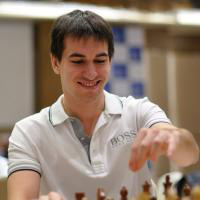

In [51]:
img_link  = df_img.iloc[434]['avatar']
# img_link = df_profiles[df_profiles['username'] == 'magnuscarlsen'].groupby('avatar').size()
img_link
response_img = requests.get(img_link)
img = Image.open(BytesIO(response_img.content))
img

In [52]:
# топ блица
df_blitz = df_stats.sort_values(by=['chess_blitz.best.rating', 'chess_blitz.record.win'], ascending=False)
df_blitz[['username', 'chess_blitz.best.rating', 'chess_blitz.last.rating', 'chess_blitz.record.win', 'chess_blitz.record.loss', 'chess_blitz.record.draw']]

,username,chess_blitz.best.rating,chess_blitz.last.rating,chess_blitz.record.win,chess_blitz.record.loss,chess_blitz.record.draw
358,zarinur,2624.0,2495.0,135.0,184.0,15.0
166,lady_nika,2615.0,2531.0,614.0,629.0,100.0
102,fariza2018,2603.0,2581.0,847.0,837.0,124.0
254,pineapplepenn,2600.0,2406.0,554.0,608.0,61.0
43,bitter-cikolata,2571.0,2494.0,64.0,77.0,12.0
...,...,...,...,...,...,...
281,rumori20,NaN,NaN,NaN,NaN,NaN
287,savvyshark,NaN,NaN,NaN,NaN,NaN
288,seydirsm,NaN,NaN,NaN,NaN,NaN
305,strukovaksenia,NaN,NaN,NaN,NaN,NaN


In [53]:
# поиск инфо по конкретному игроку через его url - поиск по никнейму Яна Непомнящего 
# df_all_stats[(df_all_stats['players.profile.url'].str.contains('lachesisq'))]

## Создаем таблицы БД и записываем в них нужные датафреймы

In [54]:
# функция для создания таблицы
sqlite_connection = sqlite3.connect('db_name')
def create_table(table_name, columns_list, path):
    query = 'CREATE TABLE IF NOT EXISTS {table} ({columns})'
    uni_query = query.format(table=table_name, columns = columns_list)
    name = '{t_name}.db'
    db_name = name.format(t_name=path)
    try:
        sqlite_connection = sqlite3.connect(db_name)
        cursor = sqlite_connection.cursor()
        print('База данных создана и успешно подключена к SQLite')

        sqlite_select_query = 'select sqlite_version();'
        cursor.execute(uni_query)
        record = cursor.fetchall()
        print('Версия базы данныхх SQLite: ', record)
        cursor.close()
    except sqlite3.Error as error:
        print('Ошибка при подключении к SQLite', error)
    finally:
        if (sqlite_connection):
            sqlite_connection.close()
            print('Соединение с SQLite закрыто')

In [55]:
# функция создания подлючения к БД
def create_connection(path):
    connection = None
    try:
        connection = sqlite3.connect(path, timeout=10)
        print('Подключение к SQLite успешно')
    except Error as e:
        print(f"Произошла ошибка '{e}'")
    return connection

In [56]:
# Запись в БД
# df - что пишем в БД, table_name - в какую таблицу
def write_sql_query(connection, query, table_name, df):
    cursor = connection.cursor()
    try:
        cursor.execute(query)
        connection.commit()
        df.to_sql(table_name, connection, if_exists='replace', index = False)
        print("Query execution is successfull")
    except sqlite3.Error as error:
        print('Ошибка при подключении к SQLite', error)
    finally:
        if (sqlite_connection):
            sqlite_connection.close()
            print('Соединение с SQLite закрыто')
    cursor.execute(query)


In [57]:
# функция для чтения из БД
def read_sql_query(connection, query_read):
    cursor = connection.cursor()
    result = None
    try:
        cursor.execute(query_read)
        result = cursor.fetchall()
        return result
    except Error as e:
        print("f'Произошла ошибка {e}'")
    finally:
        if (sqlite_connection):
            sqlite_connection.close()
            print('Соединение с SQLite закрыто')

In [58]:
def getDfColumns(df_name):
    for column_headers in df_name: 
        column_headers

In [59]:
# data_types_variables = ['stats', 'profiles', 'names']
db_type = 'profiles'
path = 'profiles'
t_name = '{titul}_{d_type}'.format(titul=title, d_type=db_type)

# try:
create_table(getDfColumns(df_profiles), t_name, path)
# except Exception as e:
#     print(f'Произошла ошибка {e}')

База данных создана и успешно подключена к SQLite
Версия базы данныхх SQLite:  []
Соединение с SQLite закрыто


In [60]:
# create_table('tt_result_table', 'username, tournament_name, tournament_id, game_id\
#     start_time, finish_time, games_count, registered_user_count',\
#         'tt_result_table')

In [61]:
# подключаемся к БД
path = 'profiles.db'
connection = create_connection(path)

Подключение к SQLite успешно


In [62]:
# пишем в БД
table_name = 'df_WCM_profiles'
df_var = df_profiles
columns_list = getDfColumns(df_stats)
query_write = 'CREATE TABLE IF NOT EXISTS {table} ({columns})'.format(table=table_name, columns = columns_list)
write_sql_query(connection, query_write, table_name, df_var)

Query execution is successfull
Соединение с SQLite закрыто


In [63]:
# читаем из БД
table_name = 'df_wcm_profiles'
query_read = 'SELECT * FROM {table}'.format(table=table_name)
read_sql_query(connection, query_read)

Соединение с SQLite закрыто


[(87160328,
  'https://api.chess.com/pub/player/1ncogn1to',
  'https://www.chess.com/member/1Ncogn1to',
  '1ncogn1to',
  'WCM',
  2,
  'https://api.chess.com/pub/country/ZA',
  1661080946,
  1595257340,
  'premium',
  0,
  0,
  None,
  None,
  None,
  None,
  None,
  'https://api.chess.com/pub/player/1ncogn1to'),
 (42155586,
  'https://api.chess.com/pub/player/aartikd',
  'https://www.chess.com/member/aartikd',
  'aartikd',
  'WCM',
  5,
  'https://api.chess.com/pub/country/ZA',
  1694597907,
  1515516071,
  'premium',
  0,
  0,
  'Bronze',
  None,
  None,
  None,
  None,
  'https://api.chess.com/pub/player/aartikd'),
 (5921628,
  'https://api.chess.com/pub/player/abdodi',
  'https://www.chess.com/member/Abdodi',
  'abdodi',
  'WCM',
  262,
  'https://api.chess.com/pub/country/IQ',
  1709046125,
  1318097634,
  'premium',
  0,
  0,
  'Crystal',
  'M. Mohsin, Suhaila',
  None,
  None,
  None,
  'https://api.chess.com/pub/player/abdodi'),
 (42724264,
  'https://api.chess.com/pub/player/a

## Формируем новые датафреймы. 
Далее перейдем к объединению данных из разных таблиц и создадим универсальную таблицу

In [64]:
# данные о профилях возьмем из БД
df_profiles = pd.read_sql_query("SELECT * FROM df_ALL_profiles", connection)
df_profiles.tail(1)

,Unnamed: 0,avatar,player_id,@id,url,name,username,title,followers,country,last_online,joined,status,is_streamer,verified,league,location,twitch_url,players.stats.url
12071,12071,https://images.chesscomfiles.com/uploads/v1/us...,34994758,https://api.chess.com/pub/player/zauraabdulla,https://www.chess.com/member/ZauraAbdulla,Zaura Abdulla,zauraabdulla,WCM,23,https://api.chess.com/pub/country/MV,1603095902,1492940119,premium,0,0,None,None,None,https://api.chess.com/pub/player/zauraabdulla


In [65]:
# # данные о профилях возьмем из csv
# df_profiles = pd.read_csv('ALL/df_all_profiles.csv')
# df_profiles['username'] = df_profiles['players.stats.url'].str.split('/').str[-1]
# df_profiles.head(5)

In [66]:
# данные о статистике возьмем из csv
df_stats = pd.read_csv('ALL/df_all_stats.csv')
df_stats['username'] = df_stats['players.profiles.url'].str.split('/').str[-1]
df_stats.head(5)

/var/folders/s3/lfklzzhj1tqgg7lx7dcc5x3m0000gn/T/ipykernel_7115/2155350413.py:2: DtypeWarning: Columns (68) have mixed types. Specify dtype option on import or set low_memory=False.
  df_stats = pd.read_csv('ALL/df_all_stats.csv')


,Unnamed: 0,chess_rapid.last.rating,chess_rapid.last.date,chess_rapid.last.rd,chess_rapid.best.rating,chess_rapid.best.date,chess_rapid.best.game,chess_rapid.record.win,chess_rapid.record.loss,chess_rapid.record.draw,...,chess_daily.tournament.count,chess_daily.tournament.highest_finish,chess960_daily.tournament.points,chess960_daily.tournament.withdraw,chess960_daily.tournament.count,chess960_daily.tournament.highest_finish,code,message,players.profiles.url,username
0,0,2477.0,1.659713e+09,67.0,2550.0,1.659100e+09,https://www.chess.com/game/live/53103644193,34.0,14.0,17.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://api.chess.com/pub/player/123lt,123lt
1,1,2244.0,1.638019e+09,168.0,2350.0,1.595647e+09,https://www.chess.com/game/live/6543549448,6.0,1.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://api.chess.com/pub/player/124chess,124chess
2,2,2386.0,1.675287e+09,103.0,2556.0,1.597419e+09,https://www.chess.com/game/live/69022308373,12.0,13.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://api.chess.com/pub/player/1977ivan,1977ivan
3,3,2565.0,1.706902e+09,43.0,2617.0,1.690311e+09,https://www.chess.com/game/live/83954946123,31.0,23.0,12.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://api.chess.com/pub/player/1stsecond,1stsecond
4,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://api.chess.com/pub/player/4thd-alpeacef...,4thd-alpeacefulmoon


In [67]:
# объединим таблицы
df_stats_analysis = pd.merge(df_profiles, df_stats[['username','chess_blitz.last.rating','chess_blitz.best.rating',\
                                               'chess_blitz.last.date','chess_blitz.last.rd', 'chess_blitz.best.date', \
                                                'chess_blitz.record.win','chess_blitz.record.loss',\
                                                  'chess_blitz.record.draw', 'chess_bullet.last.rating','chess_bullet.best.rating',\
                                                   'chess_bullet.best.date','chess_bullet.last.date',\
                                                'chess_bullet.record.win','chess_bullet.record.loss', 'chess_bullet.record.draw',\
                                                'tactics.highest.rating','tactics.highest.date','puzzle_rush.best.score', 'puzzle_rush.best.total_attempts']]\
                                                  , how = 'left', on='username')
df_stats_analysis['country'] = df_stats_analysis['country'].str.split('/').str[-1]
df_stats_analysis

,Unnamed: 0,avatar,player_id,@id,url,name,username,title,followers,country,...,chess_bullet.best.rating,chess_bullet.best.date,chess_bullet.last.date,chess_bullet.record.win,chess_bullet.record.loss,chess_bullet.record.draw,tactics.highest.rating,tactics.highest.date,puzzle_rush.best.score,puzzle_rush.best.total_attempts
0,0,https://images.chesscomfiles.com/uploads/v1/us...,18800602,https://api.chess.com/pub/player/123lt,https://www.chess.com/member/123lt,Tingjie Lei,123lt,GM,139,CN,...,2824.0,1.624890e+09,1.625236e+09,255.0,197.0,23.0,3477.0,1.661152e+09,60.0,63.0
1,1,https://images.chesscomfiles.com/uploads/v1/us...,29499974,https://api.chess.com/pub/player/124chess,https://www.chess.com/member/124chess,Дмитрий Хегай,124chess,GM,77,RU,...,2846.0,1.691862e+09,1.691867e+09,103.0,102.0,11.0,3316.0,1.643195e+09,56.0,59.0
2,2,https://images.chesscomfiles.com/uploads/v1/us...,30610578,https://api.chess.com/pub/player/1977ivan,https://www.chess.com/member/1977Ivan,Ivan Ivanisevic,1977ivan,GM,193,RS,...,2075.0,1.587320e+09,1.597411e+09,2.0,0.0,0.0,2713.0,1.595628e+09,NaN,NaN
3,3,https://images.chesscomfiles.com/uploads/v1/us...,13013662,https://api.chess.com/pub/player/1stsecond,https://www.chess.com/member/1stSecond,Nikita Meshkovs,1stsecond,GM,565,LV,...,2892.0,1.659773e+09,1.701123e+09,1055.0,857.0,154.0,4255.0,1.576940e+09,53.0,56.0
4,4,https://images.chesscomfiles.com/uploads/v1/us...,69412324,https://api.chess.com/pub/player/4thd-alpeacef...,https://www.chess.com/member/4thD-alpeacefulmoon,Robert Markus,4thd-alpeacefulmoon,GM,8,RS,...,NaN,NaN,NaN,NaN,NaN,NaN,1000.0,1.576488e+09,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12067,12067,https://images.chesscomfiles.com/uploads/v1/us...,220387731,https://api.chess.com/pub/player/yujiarun18,https://www.chess.com/member/yujiarun18,Avery Yu,yujiarun18,WCM,15,US,...,2153.0,1.696112e+09,1.709091e+09,442.0,389.0,21.0,1949.0,1.702344e+09,38.0,41.0
12068,12068,None,150255231,https://api.chess.com/pub/player/zainabma,https://www.chess.com/member/zainabMA,Zainab Darwish Almaamari,zainabma,WCM,20,AE,...,1924.0,1.636124e+09,1.684701e+09,439.0,418.0,15.0,2860.0,1.648499e+09,39.0,42.0
12069,12069,https://images.chesscomfiles.com/uploads/v1/us...,86574494,https://api.chess.com/pub/player/zaineb218,https://www.chess.com/member/zaineb218,Zaineb Hwass,zaineb218,WCM,8,TN,...,1209.0,1.597007e+09,1.685266e+09,6.0,11.0,1.0,1400.0,1.610564e+09,20.0,23.0
12070,12070,None,85888234,https://api.chess.com/pub/player/zarinur,https://www.chess.com/member/Zarinur,Zarina Nurgaliyeva,zarinur,WCM,30,KZ,...,2489.0,1.691442e+09,1.691442e+09,26.0,15.0,7.0,3550.0,1.683645e+09,60.0,63.0


In [68]:
# таблица для анализа блица
df_blitz_analysis = df_stats_analysis.filter(['username', 'title', 'country', 'joined', 'last_online', 'league', \
                                             'chess_blitz.last.rating','chess_blitz.best.rating','chess_blitz.best.date','chess_blitz.last.date',\
                                                'chess_blitz.record.win','chess_blitz.record.loss', 'chess_blitz.record.draw'])

In [69]:
df_blitz_analysis['joined'] = pd.to_datetime(df_blitz_analysis['joined'], unit='s')
df_blitz_analysis['last_online'] = pd.to_datetime(df_blitz_analysis['last_online'], unit='s')
df_blitz_analysis['chess_blitz.last.date'] = pd.to_datetime(df_blitz_analysis['chess_blitz.last.date'], unit='s')
df_blitz_analysis['chess_blitz.best.date'] = pd.to_datetime(df_blitz_analysis['chess_blitz.best.date'], unit='s')
df_blitz_analysis.sort_values(by='chess_blitz.best.rating', ascending=False).head(2)

,username,title,country,joined,last_online,league,chess_blitz.last.rating,chess_blitz.best.rating,chess_blitz.best.date,chess_blitz.last.date,chess_blitz.record.win,chess_blitz.record.loss,chess_blitz.record.draw
673,hikaru,GM,US,2014-01-06 21:20:58,2024-02-27 15:06:41,Legend,3273.0,3405.0,2024-02-09 22:59:31,2024-02-28 01:21:33,27385.0,4594.0,3571.0
920,magnuscarlsen,GM,NO,2010-08-26 21:05:20,2024-02-27 16:31:34,Champion,3264.0,3377.0,2024-01-03 21:09:14,2024-02-27 00:04:30,2030.0,447.0,388.0


In [70]:
# фильтрация
df_blitz_analysis = df_blitz_analysis.drop(df_blitz_analysis[df_blitz_analysis['chess_blitz.best.date']<='2024-01-01 00:00:00'].index)
df_blitz_analysis = df_blitz_analysis.drop(df_blitz_analysis[df_blitz_analysis['chess_blitz.best.rating']<=2000].index)
df_blitz_analysis = df_blitz_analysis.dropna()
df_blitz_analysis.head(2)

,username,title,country,joined,last_online,league,chess_blitz.last.rating,chess_blitz.best.rating,chess_blitz.best.date,chess_blitz.last.date,chess_blitz.record.win,chess_blitz.record.loss,chess_blitz.record.draw
2,1977ivan,GM,RS,2016-10-27 10:57:27,2024-02-27 21:59:46,Crystal,2735.0,2838.0,2024-01-25 13:54:55,2024-02-28 00:06:40,1011.0,575.0,129.0
4,4thd-alpeacefulmoon,GM,RS,2019-12-16 09:20:55,2024-01-27 18:21:27,Stone,2718.0,2718.0,2024-01-08 15:41:20,2024-01-08 15:41:20,10.0,0.0,3.0


In [71]:
# датафрейм с игроками только из России
df_blitz_analysis_ru = df_blitz_analysis.drop(df_blitz_analysis[df_blitz_analysis['country']!='RU'].index);

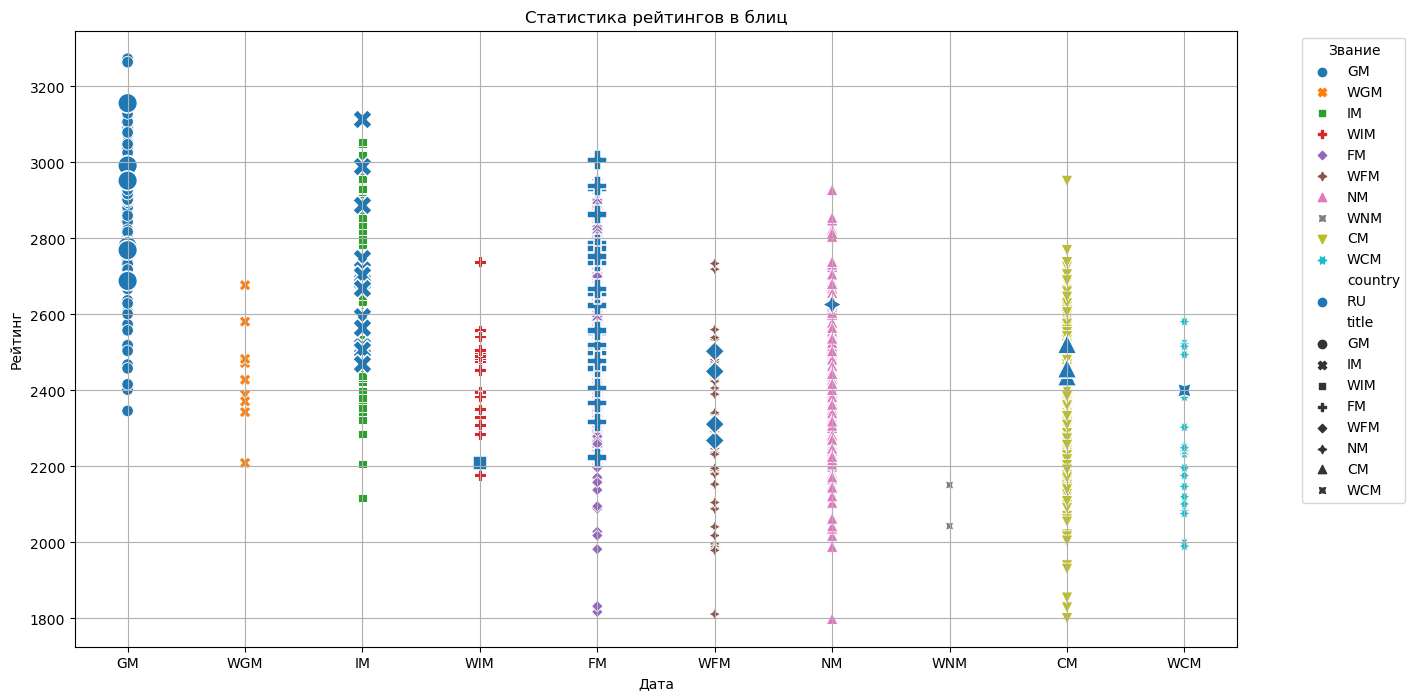

In [72]:
plt.figure(figsize=(15, 8))
sns.scatterplot(data=df_blitz_analysis, x='title', y='chess_blitz.last.rating', hue='title', style='title', s=70)
sns.scatterplot(data=df_blitz_analysis_ru, x='title', y='chess_blitz.best.rating', hue='country', style='title', s=200)

plt.title('Статистика рейтингов в блиц')
plt.xlabel('Дата')
plt.ylabel('Рейтинг')
plt.grid(True)
plt.legend(title='Звание', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

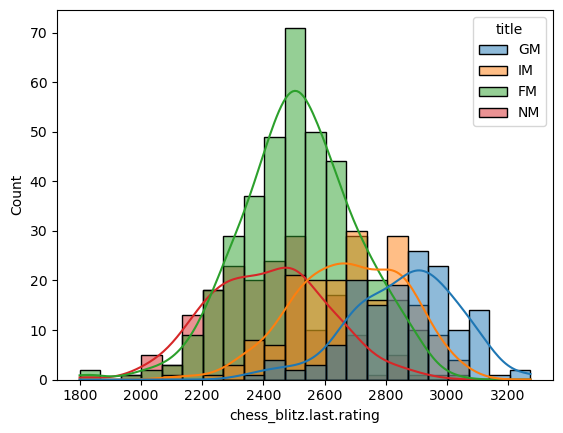

In [73]:
# сравнение GM, IM, FM, NM
df_blitz_analysis_titled = df_blitz_analysis.drop(df_blitz_analysis[~df_blitz_analysis['title'].isin(['GM','FM','IM','NM'])].index)
sns.histplot(data=df_blitz_analysis_titled, x = 'chess_blitz.last.rating', hue = 'title', kde = True);

In [74]:
# таблица для анализа пули

df_bullet_analysis = df_stats_analysis.filter(['username', 'title', 'country', 'joined', 'last_online', 'league', \
                                             'chess_bullet.last.rating','chess_bullet.best.rating','chess_bullet.best.date','chess_bullet.last.date',\
                                                'chess_bullet.record.win','chess_bullet.record.loss', 'chess_bullet.record.draw'])

In [75]:
# преобразуем форматы дат

df_bullet_analysis['joined'] = pd.to_datetime(df_bullet_analysis['joined'], unit='s')
df_bullet_analysis['last_online'] = pd.to_datetime(df_bullet_analysis['last_online'], unit='s')
df_bullet_analysis['chess_bullet.last.date'] = pd.to_datetime(df_bullet_analysis['chess_bullet.last.date'], unit='s')
df_bullet_analysis['chess_bullet.best.date'] = pd.to_datetime(df_bullet_analysis['chess_bullet.best.date'], unit='s')
df_bullet_analysis.sort_values(by='chess_bullet.best.rating', ascending=False)

,username,title,country,joined,last_online,league,chess_bullet.last.rating,chess_bullet.best.rating,chess_bullet.best.date,chess_bullet.last.date,chess_bullet.record.win,chess_bullet.record.loss,chess_bullet.record.draw
8754,chessnetwork,NM,US,2008-10-20 02:56:31,2024-02-27 19:39:21,Elite,2875.0,4200.0,2009-12-04 04:49:04,2024-02-07 10:55:45,2722.0,1939.0,315.0
673,hikaru,GM,US,2014-01-06 21:20:58,2024-02-27 15:06:41,Legend,3282.0,3570.0,2020-11-11 23:07:27,2024-02-17 18:59:18,12513.0,1745.0,782.0
311,danielnaroditsky,GM,US,2009-01-17 01:29:59,2024-02-26 19:07:30,Legend,3305.0,3553.0,2020-12-01 04:14:41,2024-02-28 05:33:12,35004.0,15566.0,3859.0
455,firouzja2003,GM,FR,2018-01-05 13:41:02,2024-02-27 21:39:56,Bronze,3197.0,3521.0,2020-11-03 00:30:59,2023-09-16 19:30:02,11596.0,7565.0,1356.0
1116,penguingm1,GM,US,2012-07-27 21:37:01,2024-02-26 23:24:37,Legend,3164.0,3504.0,2020-12-01 09:04:41,2024-02-24 18:57:06,17473.0,8549.0,1337.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12052,wcmariel,WCM,JM,2013-08-14 16:38:21,2024-01-18 15:55:18,Stone,1097.0,NaN,NaT,2015-07-04 22:28:17,0.0,4.0,0.0
12062,yarafaqeeh,WCM,PS,2020-07-15 00:02:15,2020-08-02 15:02:13,None,NaN,NaN,NaT,NaT,NaN,NaN,NaN
12064,yashami,WCM,NP,2016-09-17 18:03:56,2024-01-22 15:22:56,Silver,NaN,NaN,NaT,NaT,NaN,NaN,NaN
12065,yavotchetchemarie,WCM,CI,2021-04-18 18:16:50,2024-02-26 23:58:16,Champion,639.0,NaN,NaT,2023-11-01 19:35:49,0.0,1.0,0.0


In [76]:
# фильтрация
df_bullet_analysis = df_bullet_analysis.drop(df_bullet_analysis[df_bullet_analysis['chess_bullet.last.date']<='2024-01-01 00:00:00'].index)
df_bullet_analysis = df_bullet_analysis.drop(df_bullet_analysis[df_bullet_analysis['chess_bullet.best.rating']<=2000].index)
df_bullet_analysis = df_bullet_analysis.drop(df_bullet_analysis[df_bullet_analysis['chess_bullet.record.win']<=200].index)
df_bullet_analysis = df_bullet_analysis.drop(df_bullet_analysis[df_bullet_analysis['username']=='chessnetwork'].index)
df_bullet_analysis = df_bullet_analysis.dropna()
df_bullet_analysis.sort_values(by='chess_bullet.best.rating', ascending=False)

,username,title,country,joined,last_online,league,chess_bullet.last.rating,chess_bullet.best.rating,chess_bullet.best.date,chess_bullet.last.date,chess_bullet.record.win,chess_bullet.record.loss,chess_bullet.record.draw
673,hikaru,GM,US,2014-01-06 21:20:58,2024-02-27 15:06:41,Legend,3282.0,3570.0,2020-11-11 23:07:27,2024-02-17 18:59:18,12513.0,1745.0,782.0
311,danielnaroditsky,GM,US,2009-01-17 01:29:59,2024-02-26 19:07:30,Legend,3305.0,3553.0,2020-12-01 04:14:41,2024-02-28 05:33:12,35004.0,15566.0,3859.0
1116,penguingm1,GM,US,2012-07-27 21:37:01,2024-02-26 23:24:37,Legend,3164.0,3504.0,2020-12-01 09:04:41,2024-02-24 18:57:06,17473.0,8549.0,1337.0
1052,nihalsarin,GM,TZ,2012-04-05 17:10:59,2024-02-28 08:02:42,Legend,3166.0,3402.0,2021-09-30 16:36:32,2024-02-18 14:46:43,12622.0,6410.0,1600.0
920,magnuscarlsen,GM,NO,2010-08-26 21:05:20,2024-02-27 16:31:34,Champion,3287.0,3390.0,2023-03-27 18:26:29,2024-01-13 19:39:25,894.0,322.0,160.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10944,jan2404,CM,MX,2013-11-12 23:07:10,2024-02-27 12:35:25,Crystal,1815.0,2013.0,2023-07-28 12:57:04,2024-02-27 17:04:40,275.0,223.0,12.0
9995,stregachess,NM,US,2010-07-06 00:32:54,2024-02-27 23:40:24,Crystal,1966.0,2011.0,2024-02-23 23:05:20,2024-02-28 00:57:11,11048.0,9785.0,566.0
11463,seanyearwood,CM,TT,2016-06-29 20:11:08,2024-01-12 04:38:42,Silver,1917.0,2009.0,2023-04-13 06:51:54,2024-01-12 05:01:55,255.0,230.0,28.0
11623,ubertyce,CM,AU,2009-11-24 01:35:37,2024-02-25 02:20:13,Crystal,1879.0,2008.0,2021-04-09 05:42:28,2024-02-14 14:04:55,3325.0,2974.0,132.0


In [77]:
# датафрейм с игроками только из России
df_bullet_analysis_ru = df_bullet_analysis.drop(df_bullet_analysis[df_bullet_analysis['country']!='RU'].index);

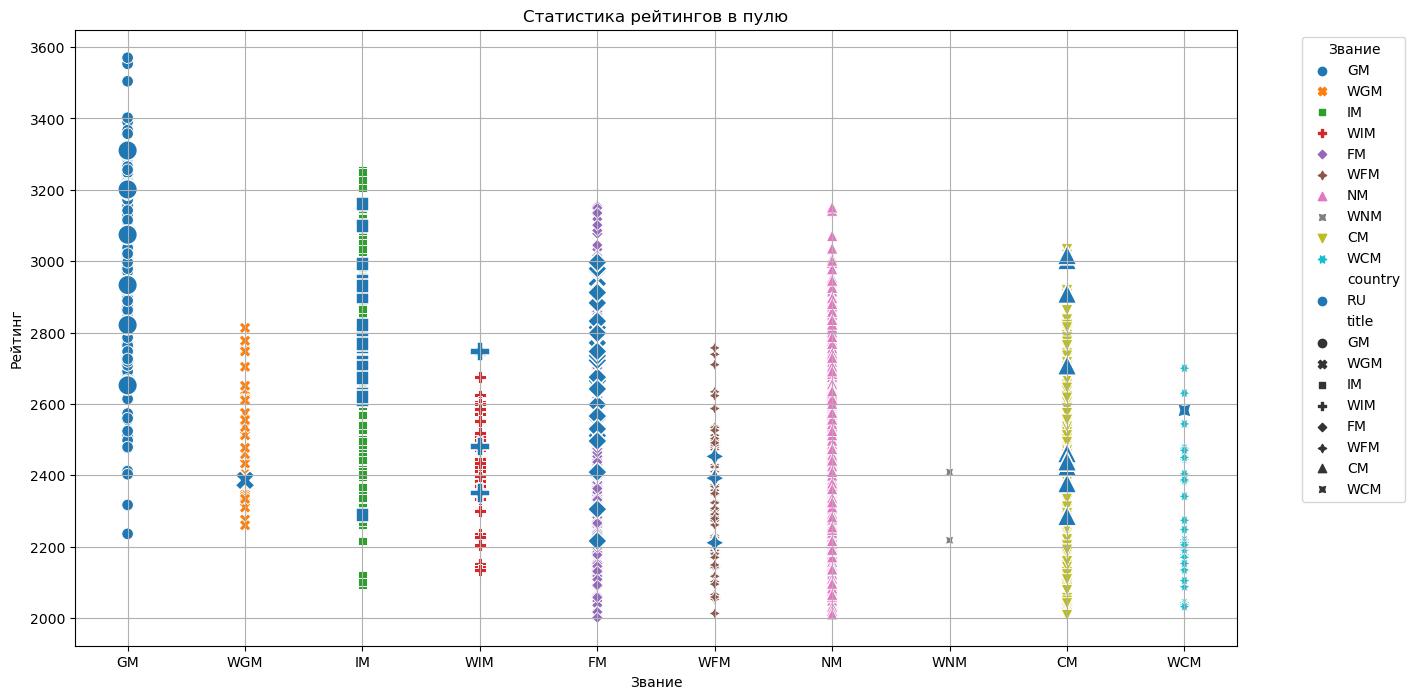

In [78]:
plt.figure(figsize=(15, 8))
sns.scatterplot(data=df_bullet_analysis, x='title', y='chess_bullet.best.rating', hue='title', style='title', s=70)
sns.scatterplot(data=df_bullet_analysis_ru, x='title', y='chess_bullet.best.rating', hue='country', style='title', s=200)

plt.title('Статистика рейтингов в пулю')
plt.xlabel('Звание')
plt.ylabel('Рейтинг')
plt.grid(True)
plt.legend(title='Звание', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

/Users/dmborisk/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:1507: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/Users/dmborisk/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:1507: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/Users/dmborisk/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:1507: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/Users/dmborisk/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:1609: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=x, y=y, **kwargs)
/Users/dmborisk/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:1609: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=x, y=y, **kwargs)
/Users/dmborisk/anaconda3/lib/python3.11/site-packages/seabo

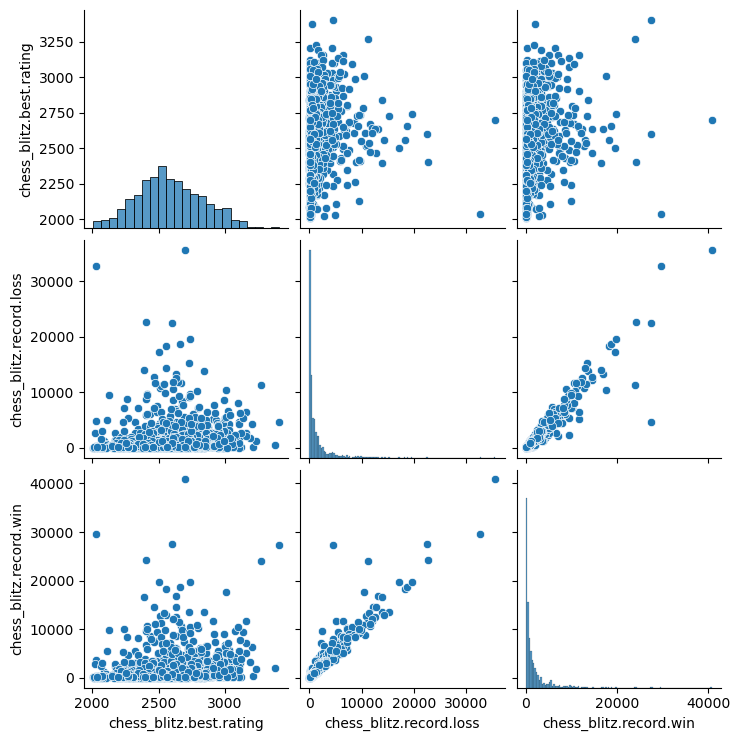

In [79]:
sns.pairplot(df_blitz_analysis[['chess_blitz.best.rating','chess_blitz.best.date', 'chess_blitz.record.loss','chess_blitz.record.win']], palette = 'husl', 
             height=2.5);

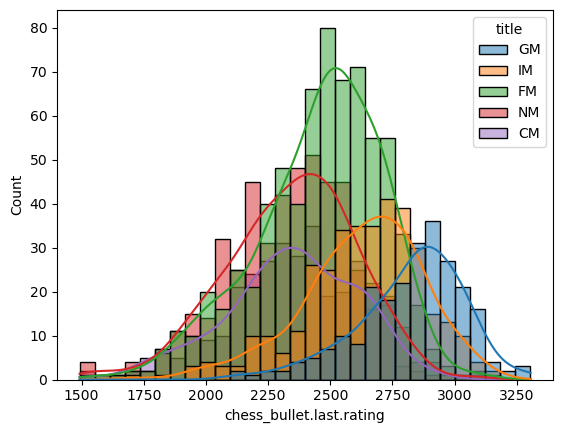

In [80]:
# сравнение GM, IM, FM, NM, CM
df_bullet_analysis_titled = df_bullet_analysis.drop(df_bullet_analysis[~df_bullet_analysis['title'].isin(['GM','FM','IM', 'NM', 'CM'])].index)
sns.histplot(data=df_bullet_analysis_titled, x = 'chess_bullet.last.rating', hue = 'title', kde = True);

In [81]:
df_tactics_analysis = df_stats_analysis.filter(['username', 'title', 'country', 'joined', 'last_online', 'league', \
                                                'tactics.highest.rating','tactics.highest.date','puzzle_rush.best.score',\
                                                    'puzzle_rush.best.total_attempts'])
df_tactics_analysis['joined'] = pd.to_datetime(df_tactics_analysis['joined'], unit='s')
df_tactics_analysis['last_online'] = pd.to_datetime(df_tactics_analysis['last_online'], unit='s')
df_tactics_analysis['tactics.highest.date'] = pd.to_datetime(df_tactics_analysis['tactics.highest.date'], unit='s')
df_tactics_analysis.sort_values(by='tactics.highest.rating', ascending=False).head()

,username,title,country,joined,last_online,league,tactics.highest.rating,tactics.highest.date,puzzle_rush.best.score,puzzle_rush.best.total_attempts
8942,el008,NM,US,2018-04-08 01:43:03,2024-02-27 13:53:34,Crystal,53064.0,2021-01-19 17:09:55,189.0,192.0
8444,2012vachamp,NM,US,2012-12-20 16:38:26,2024-02-28 06:46:19,Silver,11915.0,2018-04-24 23:43:29,69.0,72.0
10417,bad4life,CM,AT,2013-05-23 15:52:32,2024-02-27 20:08:00,Crystal,10040.0,2020-12-17 20:00:55,67.0,70.0
2413,geekphysicist,IM,HU,2021-10-17 14:17:52,2022-01-05 07:14:49,Bronze,10017.0,2022-01-03 13:53:50,47.0,50.0
3428,schachspielerr,IM,DE,2011-12-12 13:49:04,2024-02-27 20:49:53,Silver,10000.0,2023-03-16 00:27:26,163.0,166.0


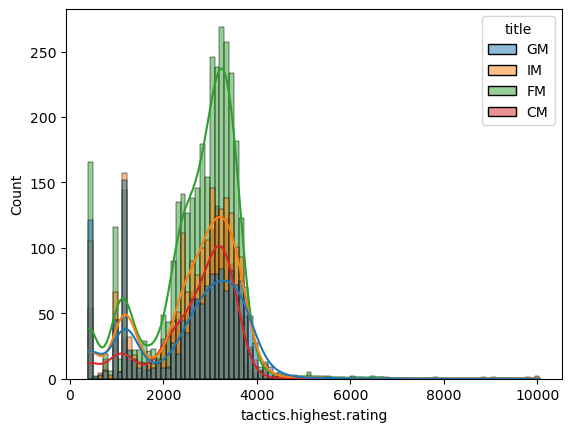

In [82]:
# сравнение GM, IM, FM
df_tactics_analysis = df_tactics_analysis.drop(df_tactics_analysis[~df_tactics_analysis['title'].isin(['GM','FM','IM','CM'])].index)
sns.histplot(data=df_tactics_analysis, x = 'tactics.highest.rating', hue = 'title', kde = True);
# sns.histplot(data=df_bullet_analysis['chess_bullet.last.rating'],kde=True);

In [83]:
df_bullet_vs_tactics= df_stats_analysis.filter(['username', 'title',\
                                                'chess_bullet.best.rating',\
                                                'chess_bullet.record.win',\
                                                'tactics.highest.rating','puzzle_rush.best.score'])

In [84]:
# избавимся от выбросов
df_bullet_vs_tactics = df_bullet_vs_tactics.drop(df_bullet_vs_tactics[df_bullet_vs_tactics['tactics.highest.rating']>=20000].index)
df_bullet_vs_tactics = df_bullet_vs_tactics.drop(df_bullet_vs_tactics[df_bullet_vs_tactics['chess_bullet.best.rating']<=2000].index)
df_bullet_vs_tactics = df_bullet_vs_tactics.dropna()
df_bullet_vs_tactics

,username,title,chess_bullet.best.rating,chess_bullet.record.win,tactics.highest.rating,puzzle_rush.best.score
0,123lt,GM,2824.0,255.0,3477.0,60.0
1,124chess,GM,2846.0,103.0,3316.0,56.0
3,1stsecond,GM,2892.0,1055.0,4255.0,53.0
5,731291,GM,2643.0,327.0,3550.0,47.0
6,a-adly,GM,3020.0,721.0,3599.0,63.0
...,...,...,...,...,...,...
12059,xhlc,WCM,2205.0,641.0,3142.0,52.0
12060,xizahk,WCM,2087.0,64.0,3100.0,37.0
12066,yoriiiis,WCM,2248.0,232.0,3119.0,47.0
12067,yujiarun18,WCM,2153.0,442.0,1949.0,38.0


/Users/dmborisk/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


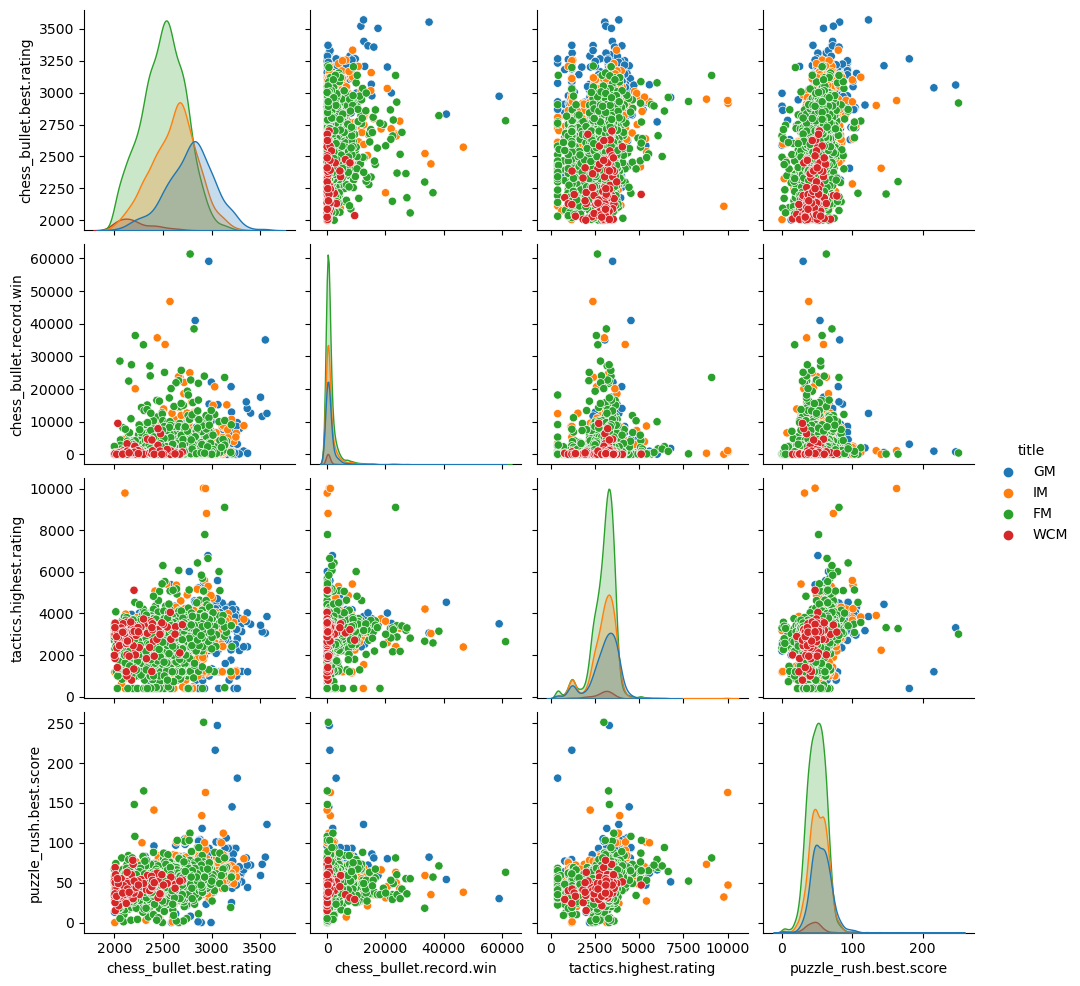

In [85]:
# выберем только 'WCM','GM','FM', 'IM'
df_bullet_vs_tactics = df_bullet_vs_tactics.drop(df_bullet_vs_tactics[~df_bullet_vs_tactics['title'].isin(['WCM','GM','FM', 'IM'])].index)
sns.pairplot(df_bullet_vs_tactics, hue = 'title')

In [86]:
df_blitz_vs_tactics= df_stats_analysis.filter(['username', 'title',\
                                                'chess_blitz.best.rating',\
                                                'chess_blitz.record.win',\
                                                'tactics.highest.rating','puzzle_rush.best.score',\
                                                    'puzzle_rush.best.total_attempts'])

/Users/dmborisk/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


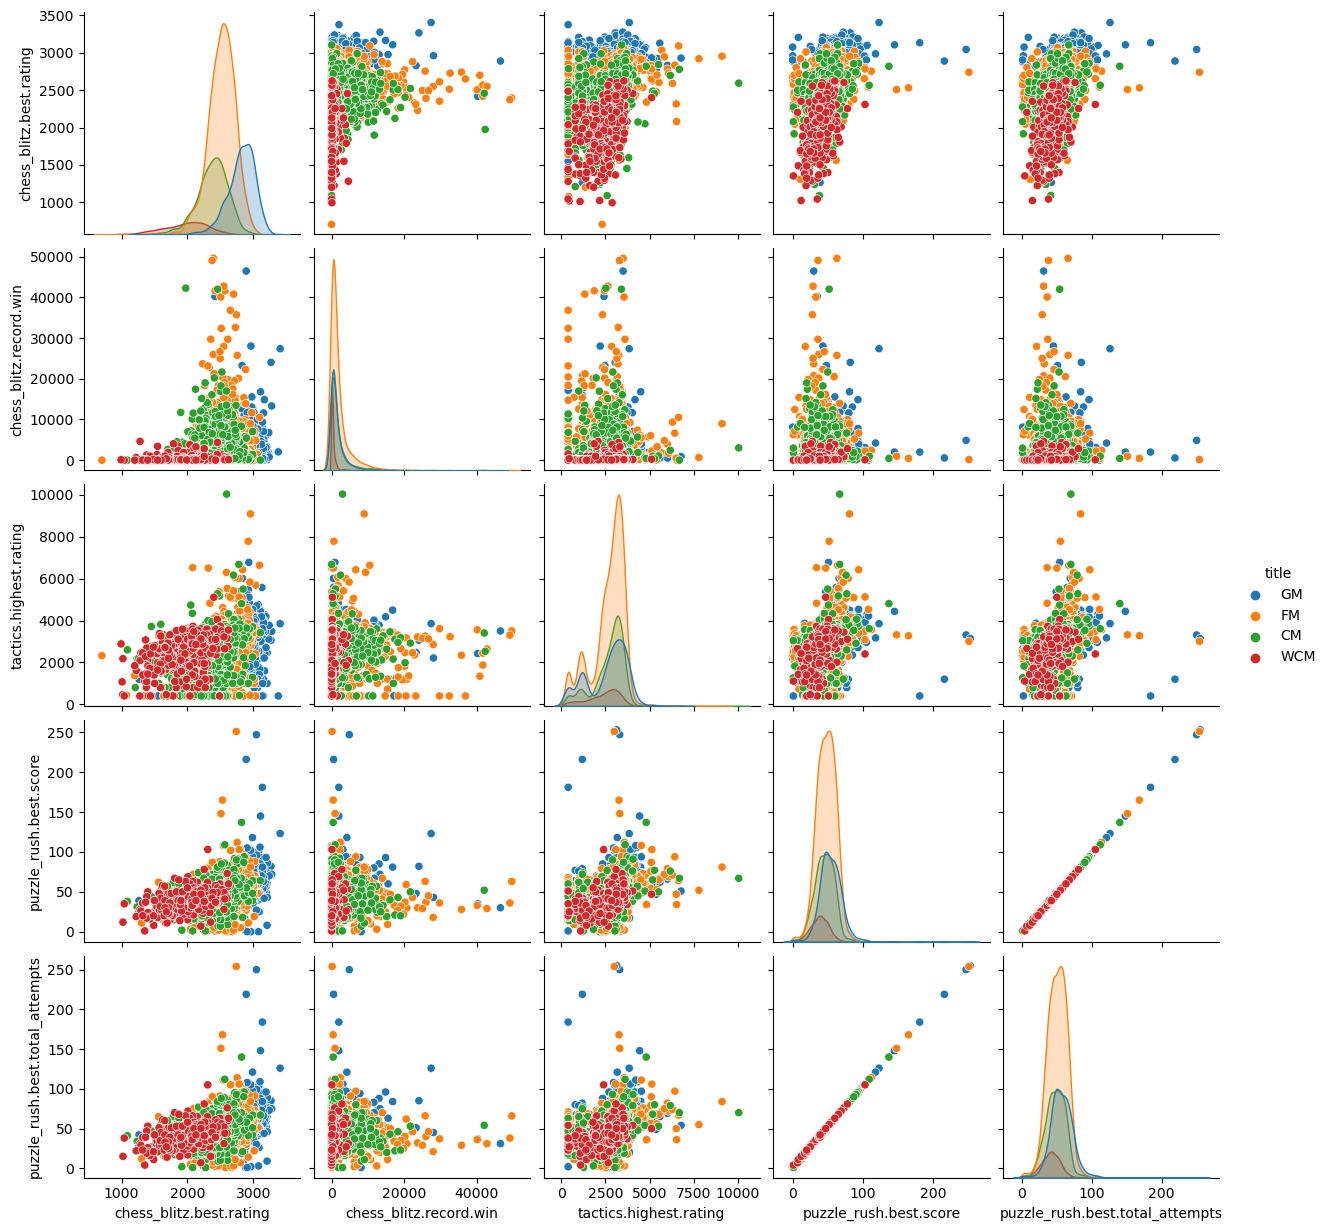

In [87]:
# выберем только 'WCM','GM','FM', 'CM'
df_blitz_vs_tactics = df_blitz_vs_tactics.drop(df_blitz_vs_tactics[~df_blitz_vs_tactics['title'].isin(['WCM','GM','FM', 'CM'])].index)
sns.pairplot(df_blitz_vs_tactics, hue = 'title')

### Выводы:
1. Шахматистов мужского пола, представляющих Россию, в топе рейтинга намного больше чем женщин.
2. Графики гистограмм по блицу и пуле носят характер нормального распределения для всех категорий шахматистов. 
3. Ожидаемо рейтинги категорий располагаются по возрастанию CM -> NM -> FM -> IM -> GM. Представителей GM ожидаемо меньше остальных.
4. График распределения "df_tactics_analysis" показывает наличие группы игроков, у которой решение тактики на платформе Chess.com не вызывает интереса.  
5. Больше всего тактику любят решать FM. Шахматистов с максимальным рейтингом в тактику примерно одинаковое количество в категориях FM, IM, GM. 
6. По графикам "sns.pairplot" видим, что высокий рейтинг в тактике и "puzzle_rush" не гарантируют безусловного успеха в пуле или блице.
Но если сравнивать успехи решения тактики женщинами и мучинами, то появляется явная корреляция между умением решать
задачки и рейтингом в реальной игре: чем выше рейтинг в задачках, тем он выше в блице и рапиде.
7. Рейтинги в пулю, блиц и тактику у женщин драматически отстают от мужских.